### Horse2zebra cyclegan

dataset, sources: https://drive.google.com/open?id=1_8ZmeCII14hmqYEwBTvTFuAD_0ueCIIZ

## Установка зависимостей

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import os
os.chdir('/content/gdrive/My Drive/cyclegan/')

In [0]:
!pip install -r requirements.txt

In [0]:
import torch.nn as nn
import torch.nn.functional as F

import argparse
import itertools

import random
import time
import glob
import datetime
import sys

from torch.autograd import Variable
import torch
# from visdom import Visdom
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image

import warnings
warnings.filterwarnings(action='ignore')

## Описание модели

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

## Вспомогательные функции

In [0]:
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))    

class Logger():
    def __init__(self, n_epochs, batches_epoch):
        # self.viz = Visdom(use_incoming_socket=False)
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = losses[loss_name].item()
            else:
                self.losses[loss_name] += losses[loss_name].item()

            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        # sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))

        # Draw images
        # for image_name, tensor in images.items():
        #     if image_name not in self.image_windows:
        #         self.image_windows[image_name] = self.viz.image(tensor2image(tensor.data), opts={'title':image_name})
        #     else:
        #         self.viz.image(tensor2image(tensor.data), win=self.image_windows[image_name], opts={'title':image_name})

        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                # if loss_name not in self.loss_windows:
                #     self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), 
                #                                                     opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
                # else:
                #     self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0

            self.epoch += 1
            self.batch = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

        

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)



## Алгоритм обучения

In [0]:
def train(epoch=0, n_epochs=4, batchSize=1, dataroot='datasets/horse2zebra/',lr=0.0002,decay_epoch=2, size=256,
          input_nc=3, output_nc=3, n_cpu=8, cuda=True):

  ###### Definition of variables ######
  # Networks
  netG_A2B = Generator(input_nc, output_nc)
  netG_B2A = Generator(output_nc, input_nc)
  netD_A = Discriminator(input_nc)
  netD_B = Discriminator(output_nc)

  netG_A2B.cuda()
  netG_B2A.cuda()
  netD_A.cuda()
  netD_B.cuda()

  netG_A2B.apply(weights_init_normal)
  netG_B2A.apply(weights_init_normal)
  netD_A.apply(weights_init_normal)
  netD_B.apply(weights_init_normal)

  # Lossess
  criterion_GAN = torch.nn.MSELoss()
  criterion_cycle = torch.nn.L1Loss()
  criterion_identity = torch.nn.L1Loss()

  # Optimizers & LR schedulers
  optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                  lr=lr, betas=(0.5, 0.999))
  optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
  optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

  lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
  lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
  lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

  # Inputs & targets memory allocation
  Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
  input_A = Tensor(batchSize, input_nc, size, size)
  input_B = Tensor(batchSize, output_nc, size, size)
  target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
  target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

  fake_A_buffer = ReplayBuffer()
  fake_B_buffer = ReplayBuffer()

  # Dataset loader
  transforms_ = [transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])]) ]
  dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True), 
                          batch_size=batchSize, shuffle=True, num_workers=n_cpu)

  # Loss plot
  logger = Logger(n_epochs, len(dataloader))
  ###################################

  ###### Training ######
  for epoch in range(epoch, n_epochs):
      for i, batch in enumerate(dataloader):
          # Set model input
          real_A = Variable(input_A.copy_(batch['A']))
          real_B = Variable(input_B.copy_(batch['B']))

          ###### Generators A2B and B2A ######
          optimizer_G.zero_grad()

          # Identity loss
          # G_A2B(B) should equal B if real B is fed
          same_B = netG_A2B(real_B)
          loss_identity_B = criterion_identity(same_B, real_B)*5.0
          # G_B2A(A) should equal A if real A is fed
          same_A = netG_B2A(real_A)
          loss_identity_A = criterion_identity(same_A, real_A)*5.0

          # GAN loss
          fake_B = netG_A2B(real_A)
          pred_fake = netD_B(fake_B)
          loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

          fake_A = netG_B2A(real_B)
          pred_fake = netD_A(fake_A)
          loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

          # Cycle loss
          recovered_A = netG_B2A(fake_B)
          loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

          recovered_B = netG_A2B(fake_A)
          loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

          # Total loss
          loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
          loss_G.backward()
          
          optimizer_G.step()
          ###################################

          ###### Discriminator A ######
          optimizer_D_A.zero_grad()

          # Real loss
          pred_real = netD_A(real_A)
          loss_D_real = criterion_GAN(pred_real, target_real)

          # Fake loss
          fake_A = fake_A_buffer.push_and_pop(fake_A)
          pred_fake = netD_A(fake_A.detach())
          loss_D_fake = criterion_GAN(pred_fake, target_fake)

          # Total loss
          loss_D_A = (loss_D_real + loss_D_fake)*0.5
          loss_D_A.backward()

          optimizer_D_A.step()
          ###################################

          ###### Discriminator B ######
          optimizer_D_B.zero_grad()

          # Real loss
          pred_real = netD_B(real_B)
          loss_D_real = criterion_GAN(pred_real, target_real)
          
          # Fake loss
          fake_B = fake_B_buffer.push_and_pop(fake_B)
          pred_fake = netD_B(fake_B.detach())
          loss_D_fake = criterion_GAN(pred_fake, target_fake)

          # Total loss
          loss_D_B = (loss_D_real + loss_D_fake)*0.5
          loss_D_B.backward()

          optimizer_D_B.step()
          ###################################

          logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                      'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                      images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})

      # Update learning rates
      lr_scheduler_G.step()
      lr_scheduler_D_A.step()
      lr_scheduler_D_B.step()

      # Save models checkpoints
      torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
      torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
      torch.save(netD_A.state_dict(), 'output/netD_A.pth')
      torch.save(netD_B.state_dict(), 'output/netD_B.pth')
  ###################################


In [0]:
train(n_epochs=20, decay_epoch=10)

Epoch 001/020 [1334/1334] -- loss_G: 8.7256 | loss_G_identity: 2.5061 | loss_G_GAN: 0.8064 | loss_G_cycle: 5.4132 | loss_D: 0.4445 -- 
Epoch 002/020 [1334/1334] -- loss_G: 7.4033 | loss_G_identity: 2.0485 | loss_G_GAN: 0.8355 | loss_G_cycle: 4.5193 | loss_D: 0.4108 -- 
Epoch 003/020 [1334/1334] -- loss_G: 6.8906 | loss_G_identity: 1.8759 | loss_G_GAN: 0.8745 | loss_G_cycle: 4.1402 | loss_D: 0.3845 -- 
Epoch 004/020 [1334/1334] -- loss_G: 6.5906 | loss_G_identity: 1.7786 | loss_G_GAN: 0.8819 | loss_G_cycle: 3.9301 | loss_D: 0.3937 -- 
Epoch 005/020 [1334/1334] -- loss_G: 6.3540 | loss_G_identity: 1.6986 | loss_G_GAN: 0.9127 | loss_G_cycle: 3.7427 | loss_D: 0.3785 -- 
Epoch 006/020 [1334/1334] -- loss_G: 6.1942 | loss_G_identity: 1.6525 | loss_G_GAN: 0.9037 | loss_G_cycle: 3.6380 | loss_D: 0.3648 -- 
Epoch 007/020 [1334/1334] -- loss_G: 5.9635 | loss_G_identity: 1.5744 | loss_G_GAN: 0.9045 | loss_G_cycle: 3.4846 | loss_D: 0.3689 -- 
Epoch 008/020 [1334/1334] -- loss_G: 5.9258 | loss_G_id

## Тестирование

In [0]:
from torchvision.utils import save_image

def test(batchSize=1, dataroot='datasets/horse2zebra/', input_nc=3, output_nc=3,
         size=256, cuda=True, n_cpu=8, generator_A2B='output/netG_A2B.pth', generator_B2A='output/netG_B2A.pth'):

  ###### Definition of variables ######
  # Networks
  netG_A2B = Generator(input_nc, output_nc)
  netG_B2A = Generator(output_nc, input_nc)

  if cuda:
      netG_A2B.cuda()
      netG_B2A.cuda()

  # Load state dicts
  netG_A2B.load_state_dict(torch.load(generator_A2B))
  netG_B2A.load_state_dict(torch.load(generator_B2A))

  # Set model's test mode
  netG_A2B.eval()
  netG_B2A.eval()

  # Inputs & targets memory allocation
  Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
  input_A = Tensor(batchSize, input_nc, size, size)
  input_B = Tensor(batchSize, output_nc, size, size)

  # Dataset loader
  transforms_ = [ transforms.ToTensor(),
                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
  dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, mode='test'), 
                          batch_size=batchSize, shuffle=False, num_workers=n_cpu)
  ###################################

  ###### Testing######

  # Create output dirs if they don't exist
  if not os.path.exists('output/A'):
      os.makedirs('output/A')
  if not os.path.exists('output/B'):
      os.makedirs('output/B')

  for i, batch in enumerate(dataloader):
      # Set model input
      real_A = Variable(input_A.copy_(batch['A']))
      real_B = Variable(input_B.copy_(batch['B']))

      # Generate output
      fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
      fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

      # Save image files
      save_image(fake_A, 'output/A/%04d.png' % (i+1))
      save_image(fake_B, 'output/B/%04d.png' % (i+1))

      sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

  sys.stdout.write('\n')

In [12]:
test()

Generated images 0140 of 0140


## Визуализация

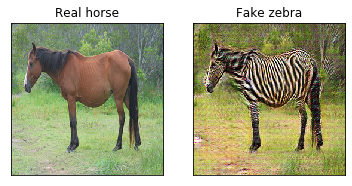

In [48]:
import matplotlib.pyplot as plt
from pathlib import Path

#horse2zebra

#img1 directory
TRAIN_DIR = Path('/content/gdrive/My Drive/cyclegan/datasets/horse2zebra/test/A')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

#img2 directory
random_pic = int(np.random.uniform(1,140))
dir2 = '/content/gdrive/My Drive/cyclegan/output/B/%04d.png' % (random_pic+1)

img1 = plt.imread(train_val_files[random_pic])
img2 = plt.imread(dir2)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img1)
axes[0].set_title('Real horse')

axes[1].imshow(img2)
axes[1].set_title('Fake zebra')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])